In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Constants
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'
IMG_SIZE = (48, 48)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 7

def create_model(input_shape=(48, 48, 3)):
    """
    Create a CNN model for emotion detection using transfer learning.

    Args:
    input_shape (tuple): The shape of the input images.

    Returns:
    tensorflow.keras.Model: The constructed CNN model.
    """
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]), input_shape=(input_shape[0], input_shape[1], 1)),  # Replicate grayscale
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def main():
    model = create_model()
    model.summary()

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_loader = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='grayscale',  # Load images in grayscale
        class_mode='categorical'
    )

    test_loader = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='grayscale',  # Load images in grayscale
        class_mode='categorical'
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint(
        'best_emotion_model.h5', 
        monitor='val_accuracy', 
        save_best_only=True
    )

    # Train the model
    model.fit(
        train_loader,
        epochs=EPOCHS,
        validation_data=test_loader,
        callbacks=[early_stopping, model_checkpoint]
    )

if __name__ == '__main__':
    main()


9406464/9406464 [==============================] - 8s 1us/step

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 48, 48, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                          

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model(input_shape=(48, 48, 1), num_classes=7):
    """
    Create a CNN model for emotion detection.

    Args:
    input_shape (tuple): The shape of the input images.
    num_classes (int): The number of emotion classes.

    Returns:
    tensorflow.keras.Model: The constructed CNN model.
    """
    model = Sequential([
        # Convolutional layer with Batch Normalization
        Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Adding more convolutional layers with increasing filters
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),

        # Flattening and Fully Connected Layers
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer for classification
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [3]:
import os
import scipy
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Constants
TRAIN_DIR = 'data/train'  # Path to training data
TEST_DIR = 'data/test'    # Path to testing data
IMG_SIZE = (48, 48)       # Image size, matching the model input
BATCH_SIZE = 32           # Batch size for training
EPOCHS = 50               # Number of epochs for training

def main():
    # Create the model
    model = create_model(input_shape=(*IMG_SIZE, 1), num_classes=7)
    model.summary()

    # Create data generators
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Create data loaders from generators
    train_loader = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, color_mode='grayscale', batch_size=BATCH_SIZE, class_mode='categorical')
    test_loader = test_datagen.flow_from_directory(TEST_DIR, target_size=IMG_SIZE, color_mode='grayscale', batch_size=BATCH_SIZE, class_mode='categorical')

    # Train the model
    model.fit(train_loader, epochs=EPOCHS, validation_data=test_loader)

    # Save the model
    model.save('emotion_detection_model.h5')

if __name__ == '__main__':
    main()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 21, 21, 128)     

d:\git\Computer-vision-emotion-detection\vision\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved model
model = tf.keras.models.load_model('emotion_detection_model.h5')

# Constants for test data
TEST_DIR = 'data/test' 
IMG_SIZE = (48, 48)  # Should match the input size used during training
BATCH_SIZE = 32

# Initialize the test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create the test data loader
test_loader = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Now you can call the evaluate_model function with this loaded model and test_loader


Found 7178 images belonging to 7 classes.


225/225 [==============================] - 9s 38ms/step - loss: 0.9687 - accuracy: 0.6414
Test Loss: 0.9687086343765259, Test Accuracy: 0.6414042711257935
225/225 [==============================] - 9s 38ms/step
              precision    recall  f1-score   support

       angry       0.52      0.60      0.56       958
     disgust       0.80      0.43      0.56       111
        fear       0.56      0.33      0.41      1024
       happy       0.83      0.85      0.84      1774
     neutral       0.57      0.65      0.61      1233
         sad       0.50      0.55      0.52      1247
    surprise       0.77      0.79      0.78       831

    accuracy                           0.64      7178
   macro avg       0.65      0.60      0.61      7178
weighted avg       0.64      0.64      0.64      7178



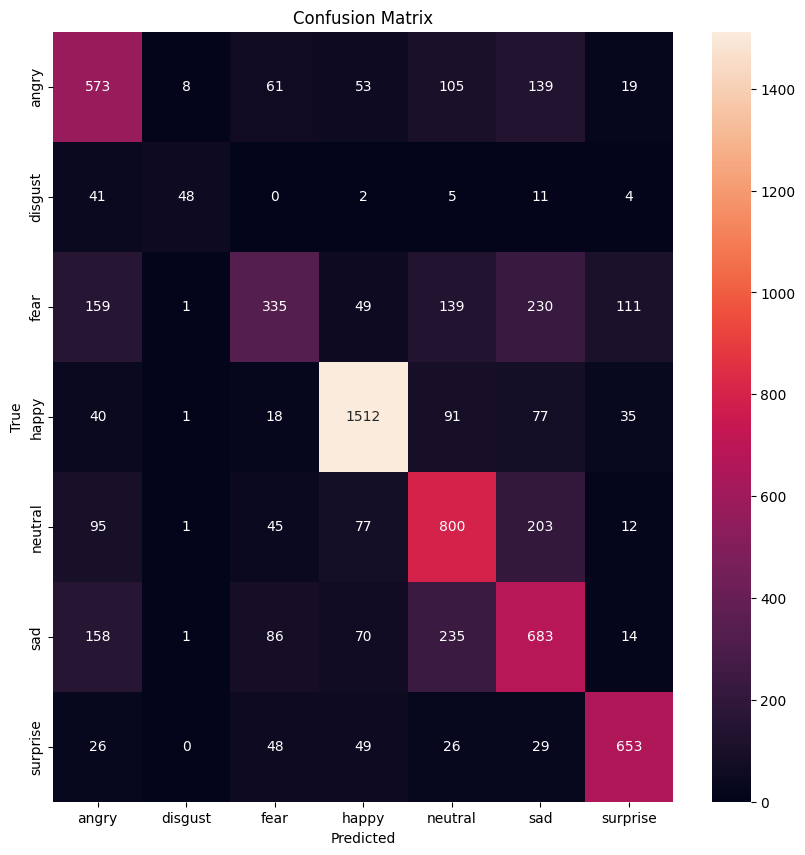

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader):
    # Evaluating the model on the test set
    test_loss, test_accuracy = model.evaluate(test_loader)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # Predictions and true labels
    predictions = model.predict(test_loader)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_loader.classes
    class_labels = list(test_loader.class_indices.keys())

    # Classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Calling the evaluation function
evaluate_model(model, test_loader)


In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = (48, 48)  # Image size, matching the model input
MODEL_PATH = 'emotion_detection_model.h5'  # Path to the saved model

# Load the saved model
model = load_model(MODEL_PATH)

# Start the webcam
cap = cv2.VideoCapture(0)

# Define the emotion labels
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the image from BGR color (which OpenCV uses) to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Resize the frame to the desired size
    resized_frame = cv2.resize(gray_frame, IMG_SIZE)

    # Normalize the image if necessary (depends on how your model was trained)
    normalized_frame = resized_frame / 255.0

    # Reshape the frame into the format expected by the model
    input_data = np.expand_dims(normalized_frame, axis=0)
    input_data = np.expand_dims(input_data, axis=-1)

    # Run the model on the image data and get the predicted emotion
    predictions = model.predict(input_data, verbose=0)[0]
    max_index = np.argmax(predictions)
    emotion_label = emotions[max_index]

    # Display a label at the top of the frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, emotion_label, (10, 50), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Display the resulting frame
    cv2.imshow('Emotion Detection', frame)

    # Press Q on keyboard to stop recording
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()
